# **1. Imports**

In [1]:
# Src: https://www.kaggle.com/code/aman10kr/offline-handwritten-text-ocr

import warnings 
warnings.filterwarnings('ignore') 

import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
import matplotlib.image as mpimg 
from matplotlib import pyplot 
import seaborn as sns  
from PIL import Image 
from glob import glob 
import os  
import random   
import cv2  

import keras  
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D  
from tensorflow.keras.layers import BatchNormalization 

# **2. Settings**

Notebook Color Scheme:


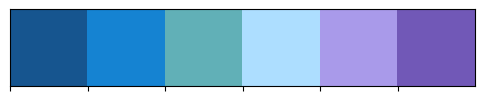

In [2]:
import matplotlib as mpl 
# Custom colors 
class color:
    S = '\033[1m' + '\033[94m' 
    E = '\033[0m' 
# Set Matplotlib graph colors 
my_colors = ["#16558F", "#1583D2", "#61B0B7", "#ADDEFF", "#A99AEA", "#7158B7"] 
print(color.S+"Notebook Color Scheme:"+color.E) 
sns.palplot(sns.color_palette(my_colors)) 
plt.show()  
# Set Matplotlib graph settings 
sns.set_style("white") 
mpl.rcParams['xtick.labelsize'] = 14 
mpl.rcParams['ytick.labelsize'] = 14 
mpl.rcParams['axes.spines.left'] = False 
mpl.rcParams['axes.spines.right'] = False 
mpl.rcParams['axes.spines.top'] = False 
plt.rcParams.update({'font.size': 14}) 

# **3. Data Exploration**

In [3]:
dir1 = './english-handwritten-characters-dataset/'

Total Number of images: 3410


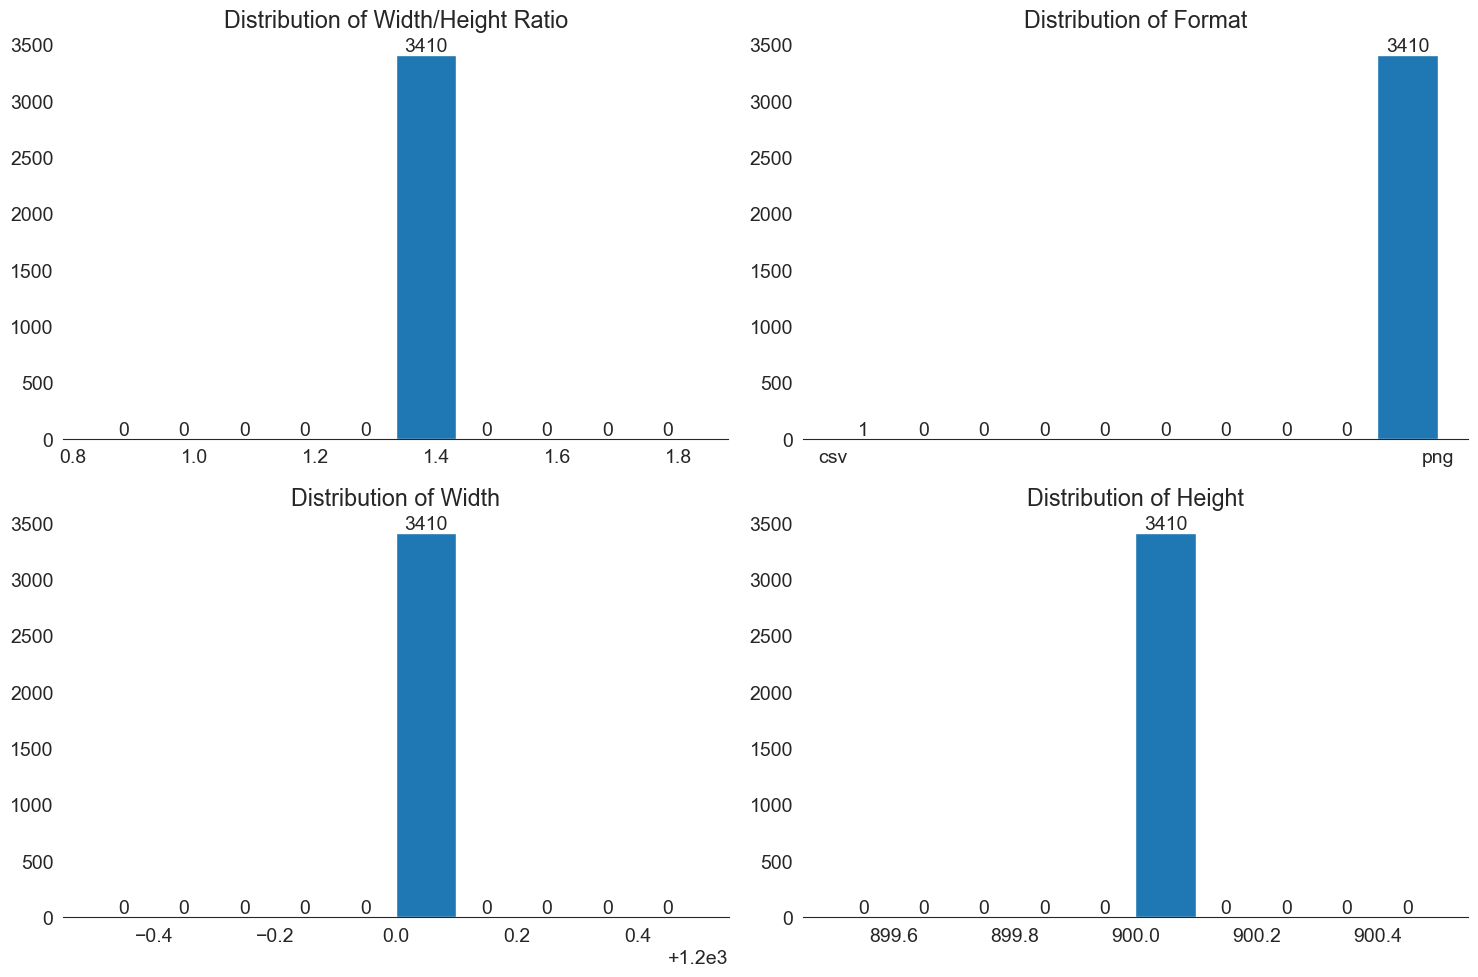

In [4]:
def plot_summary_graphs(*dir, num_samples=500):
    graph_list = {"Width/Height Ratio":[],"Format":[],"Width":[],"Height":[]}
    directories = [*dir]
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    all_files = sum([glob(os.path.join(i,'**/*.*'), recursive=True) for i in directories],[])
    graph_list["Format"] = [fp.split('.')[-1] for fp in all_files]
    print('Total Number of images: %d'%len(images))
    samples = images if num_samples==0 else random.sample(images, num_samples)
    for image in samples:
        im = Image.open(image)
        graph_list["Width"].append(im.size[0])
        graph_list["Height"].append(im.size[1])
        graph_list["Width/Height Ratio"].append(im.size[0]/im.size[1])
    plt.figure(figsize=(15,10))
    for i,k in enumerate(graph_list):
        plt.subplot(2, 2, i+1)
        # ax = sns.countplot(x=graph_list[k])
        # ax.bar_label(ax.containers[0])
        counts, edges, bars = plt.hist(graph_list[k], align="mid")
        plt.bar_label(bars)
        # plt.hist(graph_list[k], histtype='stepfilled', align='mid')
        plt.title('Distribution of '+ k)
    plt.tight_layout()
    plt.ticklabel_format(useOffset=False) # Prevents scientific notation (e.g 1.28e3) 
    plt.show()

# set num_samples to 0 to check all dir
plot_summary_graphs(dir1, num_samples=0)

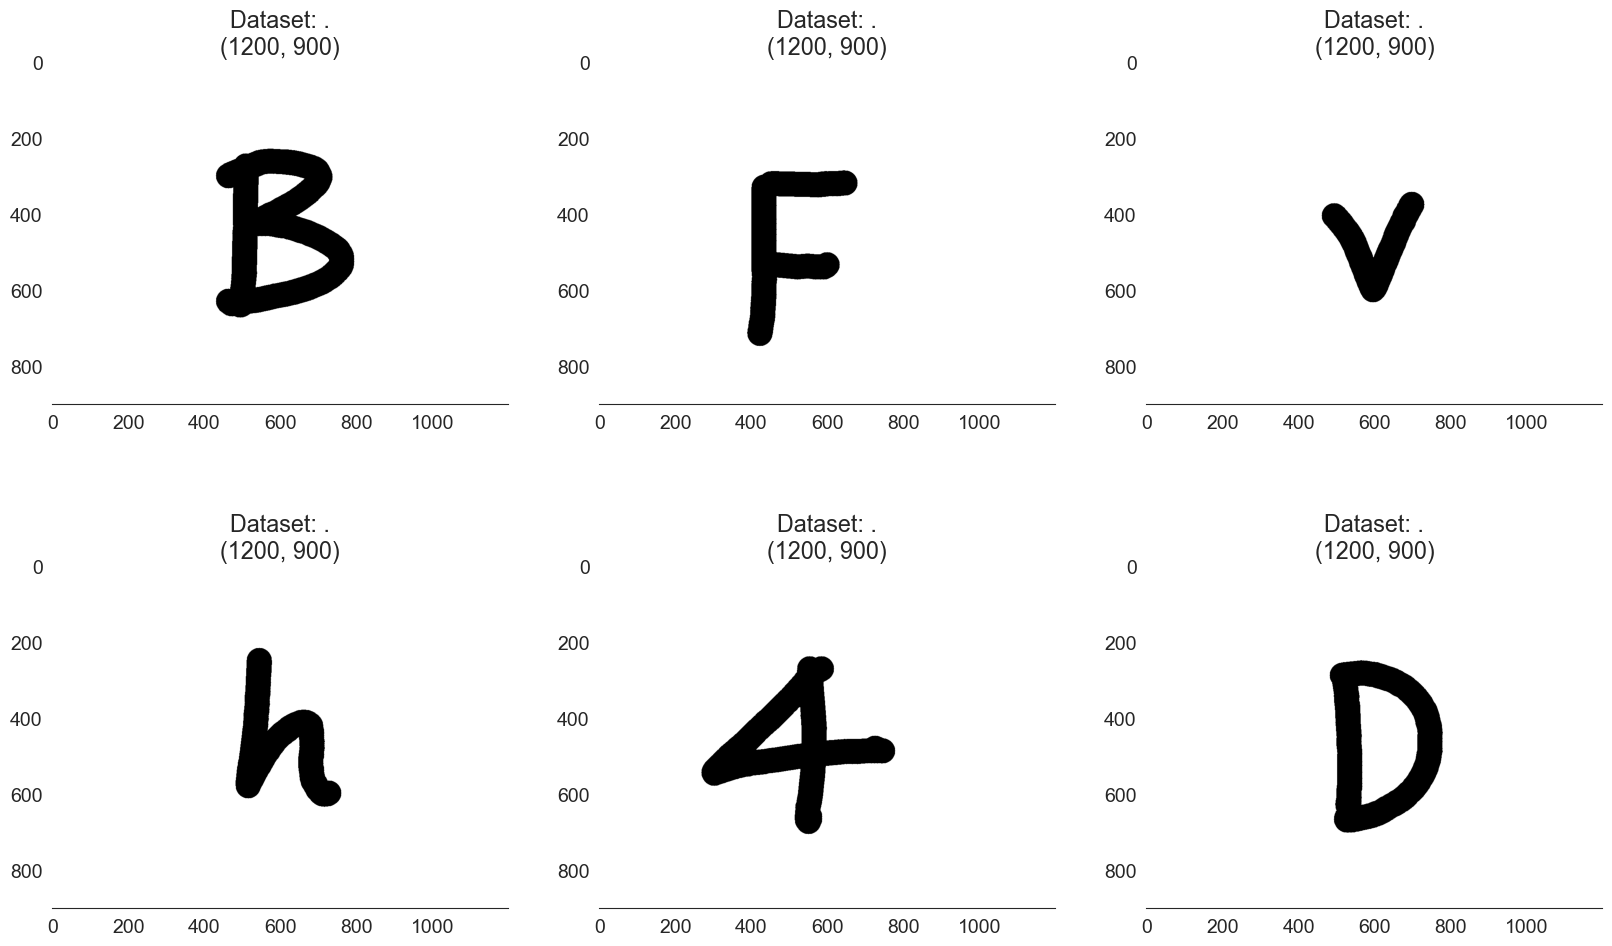

In [5]:
def plot_images_dirs(*dir, num_samples=5, num_cols=5, plot_gap=6):     
    directories = [*dir]
    images = sum([glob(os.path.join(i,j), recursive=True) for j in ("**/*.png","**/*.jpg","**/*.jpeg","**/*.bmp") for i in directories],[])
    samples = images if num_samples==0 else random.sample(images, num_samples)
    fig = plt.figure(figsize=(20,num_samples/num_cols*plot_gap)) 
    for i,image in enumerate(samples):
        plt.subplot(round(num_samples/num_cols),num_cols,i+1)   
        img = Image.open(image)   
        plt.title("Dataset: " + image.split("/")[-2] + "\n" + str(img.size))    
        plt.imshow(img)      
    plt.show()

plot_images_dirs(dir1, num_samples=6, num_cols=3, plot_gap=6)

In [6]:
img_size=(224,224)
batch_size=64

# **4. Loading Data**

In [7]:
df = pd.read_csv('./english-handwritten-characters-dataset/english.csv')

In [8]:
df["image"] = "./english-handwritten-characters-dataset/" + df["image"]

In [9]:
def df_to_array(paths, im_size=None):
    """This function provides memory friendly method to load images from dataframe to array
    paths: List or series containing image paths
    im_size: Resize images while loading. Very helpful if you get memory error.
    """
    if im_size:
        return np.array([cv2.resize(np.asarray(Image.open(path)), im_size) for path in paths], dtype = 'uint8')
    else:
        return np.array([np.asarray(Image.open(path)) for path in paths], dtype = 'uint8')

In [10]:
x = df_to_array(df["image"], im_size=img_size)

In [11]:
y = df['label'].values

# **5. Data Cleaning & Feature Engineering**

In [12]:
np.unique(y)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c',
       'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
       'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'], dtype=object)

In [13]:
#conditions = [y == 'c', y == 'f', y == 'i', y == 'j', y == 'm', y == 'o', y == 'p', y == 's', y == 'u', y == 'v', y == 'w', y == 'x', y == 'y', y == 'z']
#replacements = ['C', 'F', 'I', 'J', 'M', 'O', 'P', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z']
#y = np.select(conditions, replacements, y)

# **6. Exploratory Data Analysis**

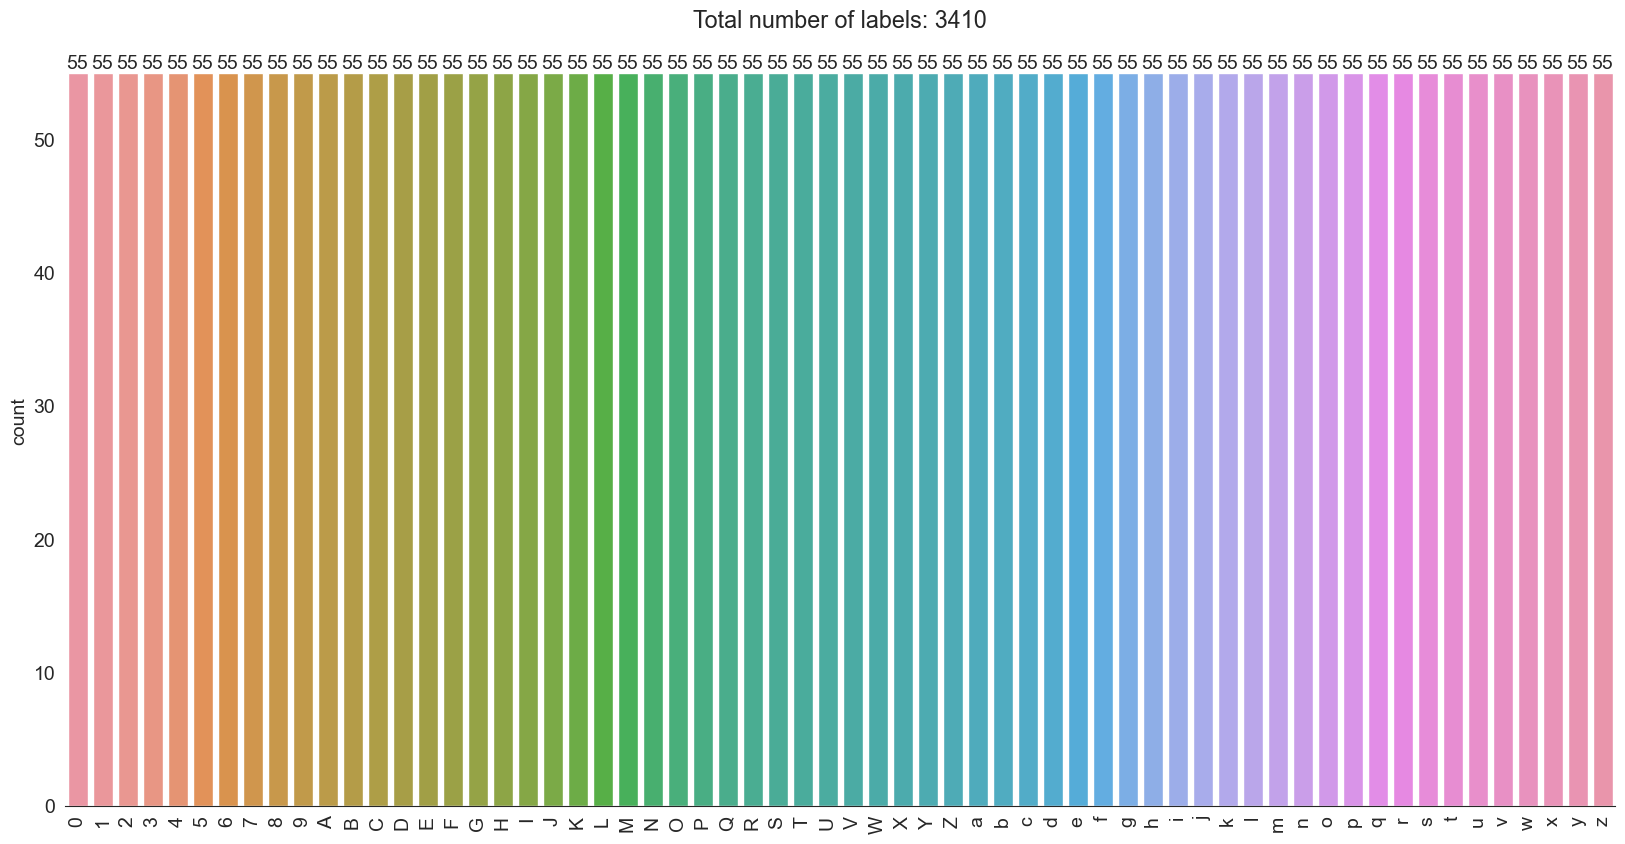

In [14]:
def plot_class_dist(*class_labels):  
    """
    Plot class distribution
    class_labels: list or series of class labels
    """
    fig = plt.figure(figsize=(20, 10))
    gs = fig.add_gridspec(len(class_labels),1) # Create subplots & specify (#rows, #columns)
    gs.update(wspace=0.2, hspace=0.2) # Specify spaces between subplot (#rows, #columns)
    for i in range(len(class_labels)):
        ax = fig.add_subplot(gs[i, 0]) # Place plot on a subplot [row,column]
        ax = sns.countplot(x=class_labels[i]) # For Array, use x=y, to change orientation: "x=" → "y="
        ax.bar_label(ax.containers[0]) # Show number on top of bars
        ax.title.set_text(f"Total number of labels: {len(class_labels[i])}")
        dummy = ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #If you have too much class, rotates x labels

plot_class_dist(y)

# **7. Image Processing**

Not required, dataset already looks perfect.

# **8. Target / Label Formatting**

In [15]:
classes = np.unique(y, return_counts=True)[0].tolist()

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(classes)
y = le.transform(y) # For Classification

# **9. Splitting Data Into Training & Test Sets**

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.1, shuffle = True, random_state = 8)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.111, shuffle = True, random_state = 8)
print(f"# Training data: {len(x_train)}, # test data: {len(x_test)}, # val data: {len(x_val)}")
print(f"# Training data: {len(x_train)/len(x)}, # test data: {len(x_test)/len(x)*100}, # val data: {len(x_val)/len(x)*100}")

# Training data: 2728, # test data: 341, # val data: 341
# Training data: 0.8, # test data: 10.0, # val data: 10.0


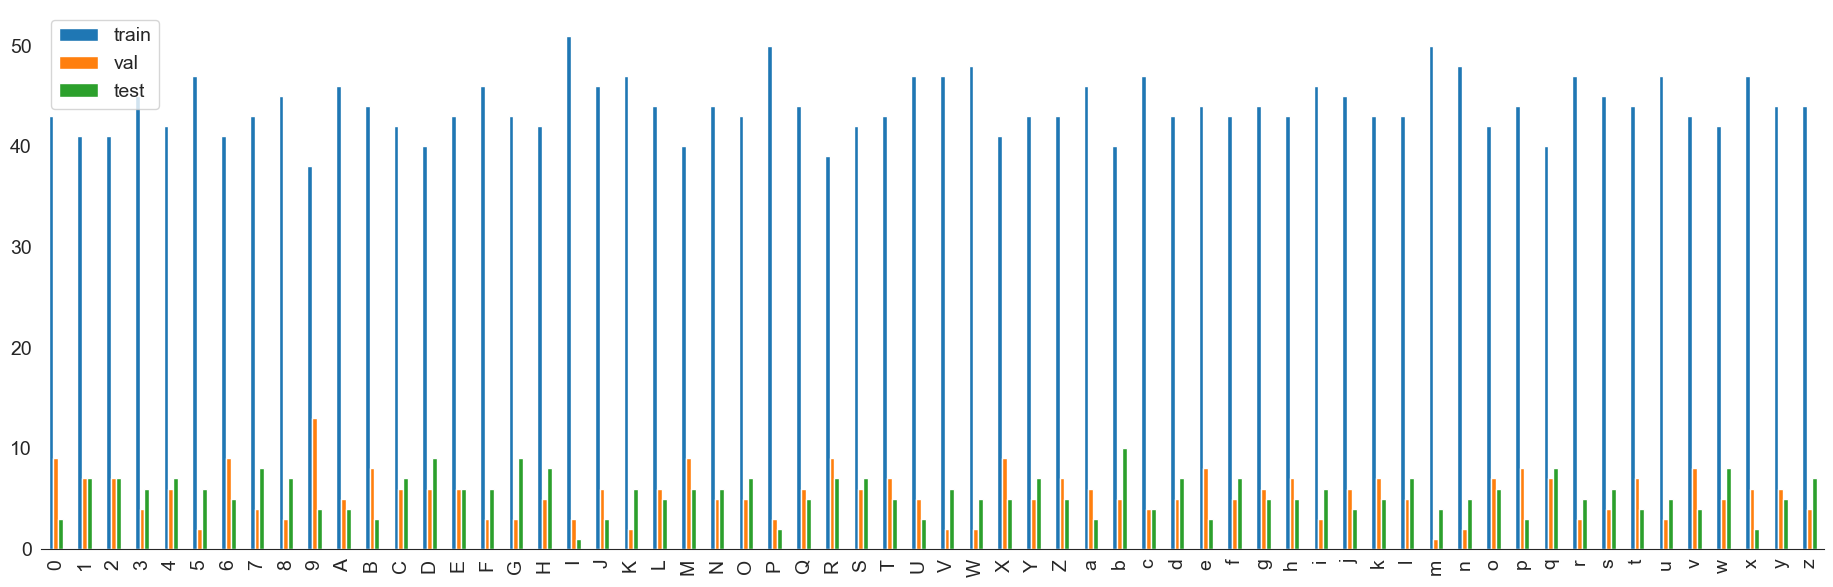

In [18]:
# For one hot decoded labels, y_train -> [label_decoder[y_train[i].argmax()] for i in range(len(y_train))]
train_values, train_counts = np.unique(y_train, return_counts=True) # Directory Iterator: xy_train.classes
val_values, val_counts = np.unique(y_val, return_counts=True) # Directory Iterator: xy_val.classes
test_values, test_counts = np.unique(y_test, return_counts=True) # Directory Iterator: xy_test.classes

fig, ax = plt.subplots(figsize=(23, 7))
pd.DataFrame({'train': train_counts,'val': val_counts, 'test': test_counts},index=classes).plot.bar(ax=ax)
plt.show() # "index=classes" if labels are encoded

# **10. Data Augmentation Of Training Data**

In [19]:
import random
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
import seaborn as sns
import os
import cv2
from PIL import Image
import albumentations as A

class ImageAugmentation:
    def __init__(self):
        pass

    @classmethod
    def preprocess(cls, x, bboxes, classes, titles, bbox_format, im_size, num_samples):
        samples = random.sample(range(len(x)),num_samples) if num_samples !=0 else range(len(x)) # Take required number of samples
        
        x = x.values.tolist() if isinstance(x, pd.Series) else x
        bboxes = bboxes.values if isinstance(bboxes, pd.Series) else bboxes
        classes = classes.values if isinstance(classes, pd.Series) else classes
        titles = titles.values if isinstance(titles, pd.Series) else titles

        bboxes = [bboxes[i] for i in samples] if bboxes is not None and num_samples !=0 else bboxes
        classes = [classes[i] for i in samples] if classes is not None and num_samples !=0 else classes
        titles = [titles[i] for i in samples] if titles is not None and num_samples !=0 else titles

        if isinstance(x, list):
            x = np.array([np.array(Image.open(x[i]).convert('RGB')) for i in samples])
        elif isinstance(x, np.ndarray):
            x = np.array([x[i] for i in samples]) if num_samples != 0 else x
        else:
            print("There's a problem with your image data format")
            return
        
        if im_size is not None:
            if bboxes is not None and (bbox_format == 'pascal_voc' or bbox_format == 'coco'):
                bboxes = copy.deepcopy(bboxes)
                for i,bbox in enumerate(bboxes):
                    for k,box in enumerate(bbox):
                        box[0] = box[0]/x[i].shape[1]*im_size[0]
                        box[1] = box[1]/x[i].shape[0]*im_size[1]
                        box[2] = box[2]/x[i].shape[1]*im_size[0]
                        box[3] = box[3]/x[i].shape[0]*im_size[1]
            x = np.array([cv2.resize(img, im_size) for img in x], dtype="uint8")               
        return x, bboxes, classes, titles

    @classmethod
    def just_plot(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, num_samples=0, im_size=None, num_cols=4, plot_gap=5, mode="plot"):
        """Doesn't make any change, useful for creating array, plotting original images, resizing or copying
        x: Array containing images or series/list containing image paths
        bboxes: Array, series or list containing bbox coordinates [[0.12, 0.12, 0.12, 0.12], [0.35, 0.52, 0.62, 0.31]]
        classes: Array, series or list contraining labels for each bbox [[plate, plate], [plate]]
        bbox_format: Format of the bboxes. 'pascal_voc', 'albumentations', 'coco' or 'yolo'
        titles: Array, series or list containing title for each image while plotting (usually filename)
        """
        x,bboxes,classes, titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        return cls._plot_or_return(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def _plot_or_return(cls, x, bboxes=None, classes=None, bbox_format=None, titles=None, num_cols=4, plot_gap=5, mode="plot"):
        if bboxes is None:
            if mode == "plot":
                titles = [""] * len(x) if titles[0]=='' else titles
                plt.figure(figsize=(23,len(x)/num_cols*plot_gap))
                for i in range(len(x)):
                    plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1)
                    plt.title(titles[i])
                    plt.imshow(x[i])
                plt.tight_layout()
                plt.show()
            elif mode == "return":
                return np.array(x, dtype="uint8")
        else:
            if classes is not None:
                bbox_labels = np.array([le.inverse_transform(i) for i in classes])
                bbox_labels = [el.tolist() if el.size > 0 else '' for el in bbox_labels]
            else:
                bbox_labels=None
            if mode=='plot':
                cls.plot_bboxes(x=x, y=bboxes, bbox_labels=bbox_labels, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap)
            elif mode=='return':
                return np.array(x), bboxes, classes, titles
    
    @classmethod
    def save(cls, x, y=None, z=None, bbox_format=None, folder_name="dataset", sub_folder_name="images", im_size=None, num_samples=0):
        """
        Save images in given folder
        x: Array containing images or dataframe column containing image paths
        y: Array, list or DF column containing labels for each image (save images for each label folder)
        z: Array, list or DF column containing names for each image (including format)
        folder_name: Name of the folder to be created in current directory to save the images
        sub_folder_name: Name of the folder to be created in folder_name to save the images
        im_size= if specified as (width,height), resize image
        """
        x,bboxes,y,z = cls.preprocess(x=x, bboxes=None, classes=y, titles=z, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)

        if sub_folder_name==0:
            if not os.path.exists(folder_name):os.mkdir(folder_name)
        else:
            if not os.path.exists(folder_name): os.mkdir(folder_name)
            if not os.path.exists(os.path.join(folder_name,sub_folder_name)): os.mkdir(os.path.join(folder_name,sub_folder_name))
            folder_name = os.path.join(folder_name,sub_folder_name)

        for i in range(len(x)):
            if y is None and z is None: # both z and y missing
                try:
                    pyplot.imsave(os.path.join(folder_name,"image %d.png" %i), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,"image %d.png" %i))
            elif z is None: # only y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                try:
                    pyplot.imsave(os.path.join(folder_name,y[i],"image %d.png" %i), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name, y[i],"image %d.png" %i))
            elif y is None: # only z exist
                try:
                    pyplot.imsave(os.path.join(folder_name,z[i]), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,z[i]))
            else: # both z and y exist
                if not os.path.exists(os.path.join(folder_name,y[i])): os.mkdir(os.path.join(folder_name,y[i]))
                try:
                    pyplot.imsave(os.path.join(folder_name,y[i],z[i]), x[i])
                except:
                    print("%s could not be copied" % os.path.join(folder_name,y[i],z[i]))

    @classmethod
    def plot_augmentations_for_single_image(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_cols=4, plot_gap=5, mode="plot"):
        """ This function Plot augmentations for single image to pick best augmentations for dataset. 
        If bboxes and classes None, plain images will be plotted.
        x: Array containing images or Series/list containing image paths
        bboxes: Series, array or list containing bbox coordinates. [[0.48, 0.53, 0.35, 0.19],[0.48, 0.53, 0.35, 0.19]]
        classes: Series, array pr list containing class of each bbox. [0, 1]
        bbox_format: Format of the bboxes. 'pascal_voc', 'albumentations', 'coco' or 'yolo'.
        im_size= if specified as (width,height), resize image
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        """
        x,bboxes,classes, titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=1, im_size=im_size)
        chosen_image = x[0].copy()
        albumentation_list = [
            A.Affine(always_apply=False, p=1, cval=(255, 255, 255)), 
            A.AdvancedBlur(always_apply=False, p=1, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
            A.Blur(always_apply=False, p=1.0, blur_limit=(5, 10)), 
            A.ChannelDropout(always_apply=False, p=1.0, channel_drop_range=(1, 2), fill_value=0), 
            A.ChannelShuffle(always_apply=False, p=1.0), 
            A.CLAHE(always_apply=False, p=1.0, clip_limit=(13, 21), tile_grid_size=(23, 10)), 
            A.ColorJitter(always_apply=False, p=1.0, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
            A.CropAndPad(p=1, percent=0.1), 
            A.Downscale(always_apply=False, p=1.0, scale_min=0.65, scale_max=0.65, interpolation=0), 
            A.Equalize(always_apply=False, p=1.0, mode='cv', by_channels=True), 
            A.FancyPCA(always_apply=False, p=1.0, alpha=0.1), 
            A.Flip(always_apply=False, p=1), # Flip either horizontally, vertically or both horizontally and vertically. 
            A.GaussNoise(always_apply=False, p=1.0, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
            A.GaussianBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigma_limit=0), 
            A.GlassBlur(always_apply=False, p=1.0, sigma=0.7, max_delta=4, iterations=2), 
            A.HorizontalFlip(always_apply=False, p=1), 
            A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(40, 50), sat_shift_limit=(20, 157), val_shift_limit=(-20, 50)), 
            A.ISONoise(always_apply=False, p=1.0, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)), 
            A.MedianBlur(always_apply=False, p=1.0, blur_limit=7), 
            A.MotionBlur(always_apply=False, p=1.0, blur_limit=(25, 33)), 
            A.MultiplicativeNoise(always_apply=False, p=1.0, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
            A.Perspective(always_apply=False, p=1.0, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
            A.PiecewiseAffine(always_apply=False, p=1), 
            A.PixelDropout(always_apply=False, p=1, dropout_prob=0.05, drop_value=0), 
            A.Posterize(always_apply=False, p=1.0, num_bits=[(0, 5), (0, 8), (0, 6)]), 
            A.RandomBrightness(always_apply=False, p=1.0, limit=(-0.4, 0.5)), 
            A.RandomBrightnessContrast(always_apply=False, p=1.0, brightness_limit=(-0.4, 0.5), contrast_limit=(-0.4, 0.5), brightness_by_max=True), 
            A.RandomContrast(always_apply=False, p=1.0, limit=(-0.9, 0.9)), 
            A.RandomCrop(always_apply=False, p=1, height=200, width=200), 
            A.RandomFog(always_apply=False, p=1.0, fog_coef_lower=0.22, fog_coef_upper=0.38, alpha_coef=1.0), 
            A.RandomGamma(always_apply=False, p=1.0, gamma_limit=(35, 150), eps=None), 
            A.RandomRain(always_apply=False, p=1.0, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
            A.RandomResizedCrop(always_apply=False, p=1.0, height=150, width=150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0), 
            A.RandomRotate90(always_apply=False, p=1.0), 
            A.RandomShadow(always_apply=False, p=1.0, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
            A.RandomSnow(always_apply=False, p=1.0, snow_point_lower=0.1, snow_point_upper=0.8, brightness_coeff=2.5), 
            A.RandomSunFlare(always_apply=False, p=1), 
            A.RandomToneCurve(always_apply=False, p=1, scale=0.8), 
            A.Resize(always_apply=False, p=1, height=500, width=500), # You normally don't need, but keep it just in case 
            A.RGBShift(always_apply=False, p=1.0, r_shift_limit=(29, 20), g_shift_limit=(-20, 150), b_shift_limit=(-20, 150)), 
            A.RingingOvershoot(always_apply=False, p=1.0, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)), 
            A.Rotate(always_apply=False, p=1.0, limit=(-90, 90), rotate_method='largest_box', crop_border=False), 
            A.SafeRotate(always_apply=False, p=1), 
            A.Sharpen(always_apply=False, p=1, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            A.ShiftScaleRotate(always_apply=False, p=1.0, rotate_limit=(-90, 90),rotate_method='largest_box'),
            A.Solarize(always_apply=False, p=1.0, threshold=(150, 150)), 
            A.Superpixels(always_apply=False, p=1.0, p_replace=0.1, n_segments=100, max_size=128, interpolation=1), 
            A.Transpose(always_apply=False, p=1.0), 
            A.ToGray(always_apply=False, p=1.0), # Might come in handy later, don't use! 
            A.ToSepia(always_apply=False, p=1.0), 
            A.VerticalFlip(always_apply=False, p=1.0)]
        
        bbox_incompatible_albumentation_list = [
            A.CenterCrop(always_apply=False, p=1.0, height=150, width=150), 
            A.Crop(always_apply=False, p=1.0, x_min=0, y_min=0, x_max=200, y_max=200), 
            A.CoarseDropout(always_apply=False, p=1.0, max_holes=50, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0), 
            A.ElasticTransform(always_apply=False, p=1.0, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=0.8, interpolation=1, border_mode=4), 
            A.GridDropout(always_apply=False, p=1.0, ratio=0.5, unit_size_min=10, unit_size_max=10, holes_number_x=10, holes_number_y=10, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None),
            A.OpticalDistortion(always_apply=False, p=1.0, distort_limit=0.4, shift_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.RandomGridShuffle(always_apply=False, p=1.0, grid=(3, 3))]
      
        titles_list = ["Original","Affine", "AdvancedBlur", "Blur","ChannelDropout", 
               "ChannelShuffle", "CLAHE", "ColorJitter","CropAndPad",  
               "Downscale","Equalize", "FancyPCA", "Flip", "GaussNoise",  
               "GaussianBlur", "GlassBlur","HorizontalFlip",  
               "HueSaturationValue", "ISONoise", "MedianBlur","MotionBlur","MultiplicativeNoise",  
               "Perspective","PiecewiseAffine", "PixelDropout", "Posterize", 
               "RandomBrightness", "RandomBrightnessContrast", "RandomContrast","RandomCrop",  
               "RandomFog", "RandomGamma","RandomRain", "RandomResizedCrop",  
               "RandomRotate90", "RandomShadow", "RandomSnow", "RandomSunFlare", "RandomToneCurve", 
               "Resize", "RGBShift", "Rotate", "RingingOvershoot", "SafeRotate", "Sharpen", "ShiftScaleRotate",  
               "Solarize", "Superpixels","Transpose", "ToGray", "ToSepia", "VerticalFlip" ]
        
        bbox_incompatible_titles_list = ['CenterCrop', 'Crop', 'CoarseDropout', 'ElasticTransform',
                           'GridDistortion', 'GridDropout', 'OpticalDistortion', 'RandomGridShuffle']

        x_aug,bboxes_aug,classes_aug = [],[],[]
        
        if bboxes is None and classes is None:
            titles_list.extend(bbox_incompatible_titles_list)
            albumentation_list.extend(bbox_incompatible_albumentation_list)
            for aug_type in albumentation_list:
                transform = A.Compose([aug_type])
                transformed = transform(image = chosen_image)
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(chosen_image)
                else:
                    x_aug.append(transformed['image'])
            x_aug.insert(0,chosen_image) #insert original image at the beginning
            if im_size is not None: x_aug = np.array([cv2.resize(x_aug[i], im_size) for i in range(len(x_aug))], dtype="uint8")
            return cls._plot_or_return(x=x_aug, titles=titles_list, num_cols=num_cols, plot_gap=plot_gap, mode=mode)
        elif bboxes is not None and classes is not None:
            chosen_bbox,chosen_id = bboxes[0].copy(),classes[0].copy()
            for aug_type in albumentation_list:
                transform = A.Compose([aug_type], bbox_params=A.BboxParams(format=bbox_format, label_fields=['category_ids'], min_visibility=0.3))
                transformed = transform(image = chosen_image, bboxes=chosen_bbox, category_ids=chosen_id)
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(chosen_image) 
                else:
                    x_aug.append(transformed['image'])
                    bboxes_aug.append(list(transformed['bboxes']))
                    classes_aug.append(transformed['category_ids'])
            x_aug.insert(0,chosen_image)
            bboxes_aug.insert(0,chosen_bbox)
            classes_aug.insert(0,chosen_id)
            return cls._plot_or_return(x=x_aug, bboxes=bboxes_aug, classes=classes_aug, titles=titles_list, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def augment_images(cls, x, bboxes=None, classes=None, titles=None, bbox_format=None, im_size=None, num_samples=0, num_cols=2, plot_gap=6, mode="plot"):
        """
        Create new batch from dataset after applying augmentation
        x: Array containing images or dataframe column containing image paths
        im_size= if specified as (width,height), resize image
        num_samples: If x is too large, you may only crop & plot few random samples
        num_cols: Column size while plotting. Set it 2 or 3 to see more details
        plot_gap: To increase image size or if images nest together, increase plot_gap size
        mode: plot → plot samples to find best parameters | return → returns new array with cropped imgs
        """
        x,bboxes,classes,titles = cls.preprocess(x=x, bboxes=bboxes, classes=classes, titles=titles, bbox_format=bbox_format, num_samples=num_samples, im_size=im_size)
        
        albumentation_list = [
            A.Affine(always_apply=False, p=0.5, cval=(255, 255, 255)), 
            A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
            A.Blur(always_apply=False, p=0.5, blur_limit=(5, 10)), 
            A.ChannelDropout(always_apply=False, p=0.5, channel_drop_range=(1, 2), fill_value=0), 
            A.ChannelShuffle(always_apply=False, p=0.5), 
            A.CLAHE(always_apply=False, p=0.5, clip_limit=(13, 21), tile_grid_size=(23, 10)), 
            A.ColorJitter(always_apply=False, p=0.5, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), 
            #A.CropAndPad(p=0.5, percent=0.1), 
            A.Downscale(always_apply=False, p=0.5, scale_min=0.15, scale_max=0.45, interpolation=0), 
            A.Equalize(always_apply=False, p=0.5, mode='cv', by_channels=True), 
            A.FancyPCA(always_apply=False, p=0.5, alpha=0.1), 
            A.Flip(always_apply=False, p=0.5), # Flip either horizontally, vertically or both horizontally and vertically. 
            A.GaussNoise(always_apply=False, p=0.5, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
            A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=0), 
            A.GlassBlur(always_apply=False, p=0.5, sigma=0.7, max_delta=4, iterations=2), 
            A.HorizontalFlip(always_apply=False, p=0.5), 
            A.HueSaturationValue(always_apply=False, p=0.5, hue_shift_limit=(40, 50), sat_shift_limit=(20, 157), val_shift_limit=(-20, 50)), 
            A.ISONoise(always_apply=False, p=0.5, intensity=(0.1, 0.5), color_shift=(0.25, 0.85)), 
            A.MedianBlur(always_apply=False, p=0.5, blur_limit=7), 
            A.MotionBlur(always_apply=False, p=0.5, blur_limit=(25, 33)), 
            A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
            A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
            A.PiecewiseAffine(always_apply=False, p=0.5), 
            A.PixelDropout(always_apply=False, p=0.5, dropout_prob=0.05, drop_value=0), 
            A.Posterize(always_apply=False, p=0.5, num_bits=[(0, 5), (0, 8), (0, 6)]), 
            A.RandomBrightness(always_apply=False, p=0.5, limit=(-0.4, 0.5)), 
            A.RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.4, 0.5), contrast_limit=(-0.4, 0.5), brightness_by_max=True), 
            A.RandomContrast(always_apply=False, p=0.5, limit=(-0.9, 0.9)), 
            #A.RandomCrop(always_apply=False, p=0.5, height=200, width=200), 
            A.RandomFog(always_apply=False, p=0.5, fog_coef_lower=0.22, fog_coef_upper=0.38, alpha_coef=1.0), 
            A.RandomGamma(always_apply=False, p=0.5, gamma_limit=(35, 150), eps=None), 
            A.RandomRain(always_apply=False, p=0.5, slant_lower=-10, slant_upper=10, drop_length=20, drop_width=1, drop_color=(0, 0, 0), blur_value=4, brightness_coefficient=0.5, rain_type=None), 
            A.RandomResizedCrop(always_apply=False, p=0.5, height=150, width=150, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333), interpolation=0), 
            A.RandomRotate90(always_apply=False, p=0.5), 
            A.RandomShadow(always_apply=False, p=0.5, shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5), 
            A.RandomSnow(always_apply=False, p=0.5, snow_point_lower=0.1, snow_point_upper=0.8, brightness_coeff=2.5), 
            A.RandomSunFlare(always_apply=False, p=0.5), 
            A.RandomToneCurve(always_apply=False, p=0.5, scale=0.8), 
            #A.Resize(always_apply=False, p=0.5, height=500, width=500), # You normally don't need, but keep it just in case 
            A.RGBShift(always_apply=False, p=0.5, r_shift_limit=(29, 20), g_shift_limit=(-20, 150), b_shift_limit=(-20, 150)), 
            A.RingingOvershoot(always_apply=False, p=0.5, blur_limit=(7, 15), cutoff=(0.7853981633974483, 1.5707963267948966)), 
            A.Rotate(always_apply=False, p=0.5, limit=(-90, 90), rotate_method='largest_box', crop_border=False), 
            A.SafeRotate(always_apply=False, p=0.5), 
            A.Sharpen(always_apply=False, p=0.5, alpha=(0.2, 0.5), lightness=(0.5, 1.0)), 
            A.ShiftScaleRotate(always_apply=False, p=0.5, rotate_limit=(-90, 90),rotate_method='largest_box'), 
            A.Solarize(always_apply=False, p=0.5, threshold=(150, 150)), 
            A.Superpixels(always_apply=False, p=0.5, p_replace=0.1, n_segments=100, max_size=128, interpolation=1), 
            A.Transpose(always_apply=False, p=0.5), 
            A.ToGray(always_apply=False, p=0.5), # Might come in handy later, don't use! 
            A.ToSepia(always_apply=False, p=0.5), 
            A.VerticalFlip(always_apply=False, p=0.5)]
        
        bbox_incompatible_albumentation_list = [
            A.CenterCrop(always_apply=False, p=0.5, height=150, width=150),
            A.Crop(always_apply=False, p=0.5, x_min=0, y_min=0, x_max=200, y_max=200),
            A.CoarseDropout(always_apply=False, p=0.5, max_holes=50, max_height=15, max_width=15, min_holes=None, min_height=None, min_width=None, fill_value=0), 
            A.ElasticTransform(always_apply=False, p=0.5, alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.GridDistortion(always_apply=False, p=0.5, num_steps=5, distort_limit=0.8, interpolation=1, border_mode=4), 
            A.GridDropout(always_apply=False, p=0.5, ratio=0.5, unit_size_min=10, unit_size_max=10, holes_number_x=10, holes_number_y=10, shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=None),
            A.OpticalDistortion(always_apply=False, p=0.5, distort_limit=0.4, shift_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None),
            A.RandomGridShuffle(always_apply=False, p=0.5, grid=(3, 3))]
        
        x_aug,bboxes_aug,classes_aug = [],[],[]
        
        if bboxes is None and classes is None:
            albumentation_list.extend(bbox_incompatible_albumentation_list)
            for i in range(len(x)):
                transform = A.Compose([A.SomeOf(albumentation_list, 3, replace=True, p=1)])
                transformed = transform(image = x[i].copy())
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(x[i])
                else:
                    x_aug.append(transformed['image'])
                    
            if im_size[0]!="": x_aug = np.array([cv2.resize(x_aug[i], im_size) for i in range(len(x_aug))], dtype="uint8")
                
            return cls._plot_or_return(x=x_aug, num_cols=num_cols, plot_gap=plot_gap, mode=mode)
        elif bboxes is not None and classes is not None:
            if len(bboxes) != len(classes) or len(classes) != len(x): return print('You should have same #images, #bboxes and #classes')
            for i in range(len(x)):
                transform = A.Compose([A.SomeOf(albumentation_list, 3, replace=True, p=1)], bbox_params=A.BboxParams(format=bbox_format, label_fields=['category_ids'], min_visibility=0.3))
                transformed = transform(image = x[i].copy(),bboxes=bboxes[i].copy(),category_ids=classes[i].copy())
                if np.isnan(transformed['image']).any() or transformed['image'].max() > 255 or transformed['image'].min() < 0:
                    x_aug.append(x[i])
                    bboxes_aug.append([''])
                    classes_aug.append([''])
                else:
                    x_aug.append(transformed['image'])
                    bboxes_aug.append(list(transformed['bboxes']))
                    classes_aug.append(transformed['category_ids'])
            return cls._plot_or_return(x=x_aug, bboxes=bboxes_aug, classes=classes_aug, titles=titles, bbox_format=bbox_format, num_cols=num_cols, plot_gap=plot_gap, mode=mode)

    @classmethod
    def plot_bboxes(cls, x, y, bbox_labels=None, titles=None, bbox_format="albumentations", num_cols=3, plot_gap=2): 
        """ 
        Plot images with bboxes from array or dataframe 
        x: Image array generated by cv2.imread("img.jpg")[..., ::-1] or image_path column of dataframe 
        y: Array or dataframe column containing bbox coordinates  
        bbox_labels: array or dataframe column containing labels for each bboxes 
        indexes: indexes of the images as a list you want to plot (e.g tinybox_indexes or [1, 64, 53]) 
        titles: array or dataframe column containing title for each image while plotting(usually filename)
        bbox_format: "albumentations", "pascal_voc", "coco" or "yolo" based on bbox format of your data  
        """ 
        # Turn filenames into desired list format 
        titles = [""] * len(x) if titles is None else titles
        
        width,height = [a.shape[1] for a in x], [a.shape[0] for a in x]
        
        plt.figure(figsize=(20,len(x)/num_cols*plot_gap)) # Increase plot_gap if images nested together
        for i,bboxes in enumerate(y): 
            img = x[i] if x[i].max() <= 1 else x[i]/255 
            if len(bboxes) == 0:
                plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1) 
                plt.title(str(titles[i]) + "\n" + str(img.shape)) 
                plt.imshow(img) 
                continue 
            else:
                for k, bbox in enumerate(bboxes): 
                    if bbox_format=="albumentations": 
                        [x1,y1,x2,y2] = [bbox[0]*width[i], bbox[1]*height[i], bbox[2]*width[i], bbox[3]*height[i]] 
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                    elif bbox_format=="pascal_voc": 
                        [x1,y1,x2,y2] = bbox 
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]] 
                    if bbox_format=="yolo": 
                        xcenter, ycenter, w, h = bbox
                        x1 = int((xcenter - w / 2) * width[i])
                        x2 = int((xcenter + w / 2) * width[i])
                        y1 = int((ycenter - h / 2) * height[i])
                        y2 = int((ycenter + h / 2) * height[i])
                        if x1 < 0: x1 = 0
                        if x2 > width[i] - 1: x2 = width[i] - 1
                        if y1 < 0: y1 = 0
                        if y2 > height[i] - 1: y1 = height[i] - 1
                    if bbox_format=="coco":
                        x1, y1, w, h = bbox
                        x2, y2 = x1 + w, y1 + h
                        [x1,y1,x2,y2] = [int(x) for x in [x1,y1,x2,y2]]
                    plt.subplot(int(len(x)/num_cols)+1,num_cols,i+1)
                    cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)
                    if bbox_labels is not None: cv2.putText(img, bbox_labels[i][k], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 4)
                    plt.title(str(titles[i]) + "\n" + str(img.shape))
                plt.imshow(img)

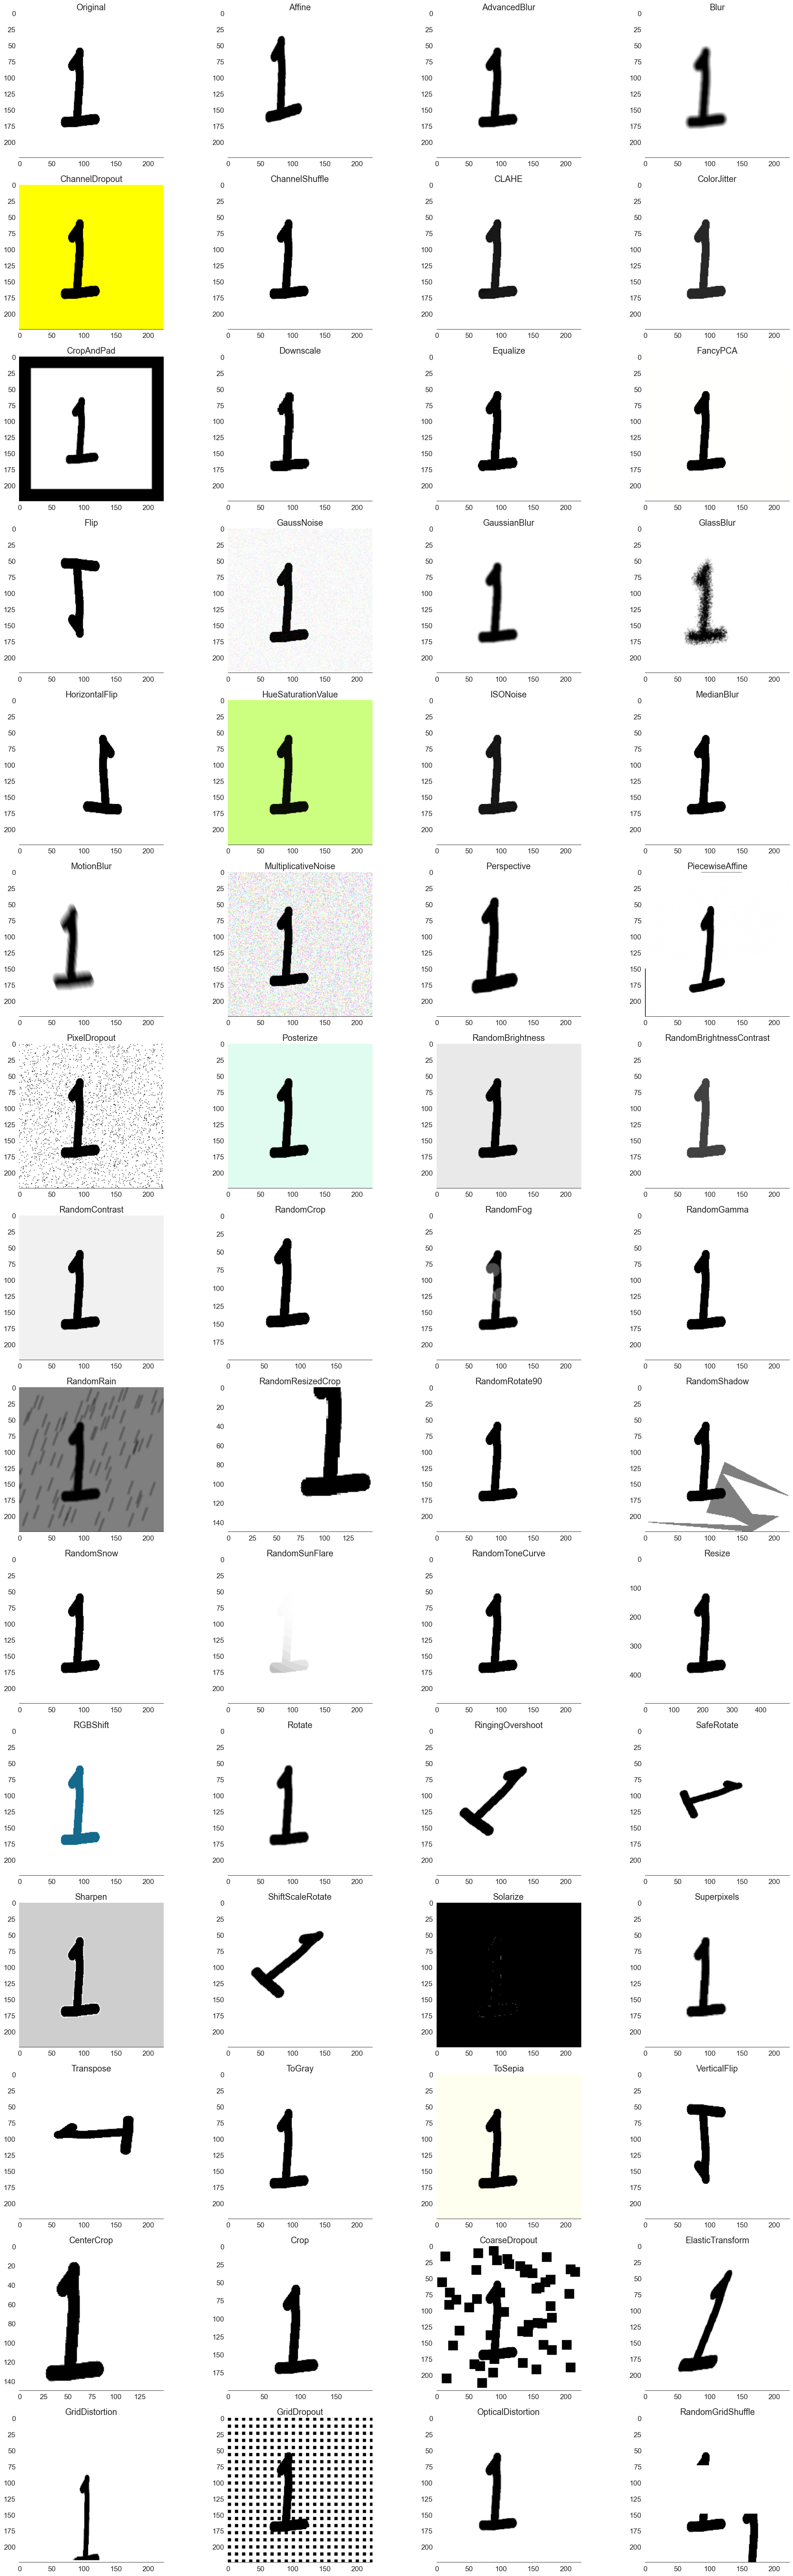

In [20]:
ImageAugmentation.plot_augmentations_for_single_image(x)
# Based on plotted augmentations, I select these augmentations
#affine
# advancedBlur
# Blur
# Downscale
# GaussNoise
# Gaussianblur
#glassblur
# multicaptivenoise
# perspective
# piecewiseaffine
# pixeldropout

In [21]:
# Apply Albumentations augmentation
import albumentations as A
def albumentations_aug(image):
    aug = A.Compose([
        A.SomeOf([
            A.Affine(always_apply=False, p=0.5, cval=(255, 255, 255)), 
            A.AdvancedBlur(always_apply=False, p=0.5, blur_limit=(3, 13), sigmaX_limit=(0.2, 1.0), sigmaY_limit=(0.2, 1.0), rotate_limit=90, beta_limit=(0.5, 8.0), noise_limit=(0.9, 1.1)), 
            A.Blur(always_apply=False, p=0.5, blur_limit=(5, 10)), 
            A.Downscale(always_apply=False, p=0.5, scale_min=0.6, scale_max=0.95, interpolation=0), 
            #   A.GaussNoise(always_apply=False, p=0.5, var_limit=(150.0, 350.0), per_channel=True, mean=0.0), 
            A.GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=0), 
            A.GlassBlur(always_apply=False, p=0.5, sigma=0.7, max_delta=2, iterations=2), 
            #   A.MultiplicativeNoise(always_apply=False, p=0.5, multiplier=(0.6, 1.7), per_channel=True, elementwise=True), 
            A.Perspective(always_apply=False, p=0.5, scale=(0.05, 0.1), keep_size=True, pad_mode=0, pad_val=0, mask_pad_val=0, fit_output=False, interpolation=1), 
            #   A.PiecewiseAffine(always_apply=False, p=0.5), 
            # A.PixelDropout(always_apply=False, p=0.5, dropout_prob=0.05, drop_value=0), 
            ], 1, replace=True, p=1)
            ])
    return aug(image=image)['image']

In [22]:
from keras.preprocessing.image import ImageDataGenerator
# Loading + Augmentation Function For Training Data 
data_generator = ImageDataGenerator(
        rescale=1./255, # Normalize pixels while loading
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        preprocessing_function = albumentations_aug
)

In [23]:
val_generator = ImageDataGenerator(
        rescale=1./255) # Normalize pixels while loading 

In [24]:
import gc
gc.collect()

191295

In [25]:
xy_train = data_generator.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=True, # (default: True) For training data, it must be True
    seed=16,
) 

In [26]:
# Load (x_val, y_val) YOU DON'T ACTUALLY NEED THIS FOR VALIDATION DATA, JUST USE x_val, y_val
xy_val = val_generator.flow(
    x_val,
    y_val,
    batch_size=batch_size,
    shuffle=True, # (default: True) For validation data, it can be True or False – True preffered
    seed=16) # Only used if validation_split is set !!!

In [27]:
import random

def show_augmented_images(datagenerator, num_cols=3, num_samples=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_samples):
        plt.subplot(num_samples // num_cols, num_cols, i + 1)
        batch = datagenerator.next()[0] * 255
        image = batch[0].astype('uint8')
        plt.imshow(image)
        plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

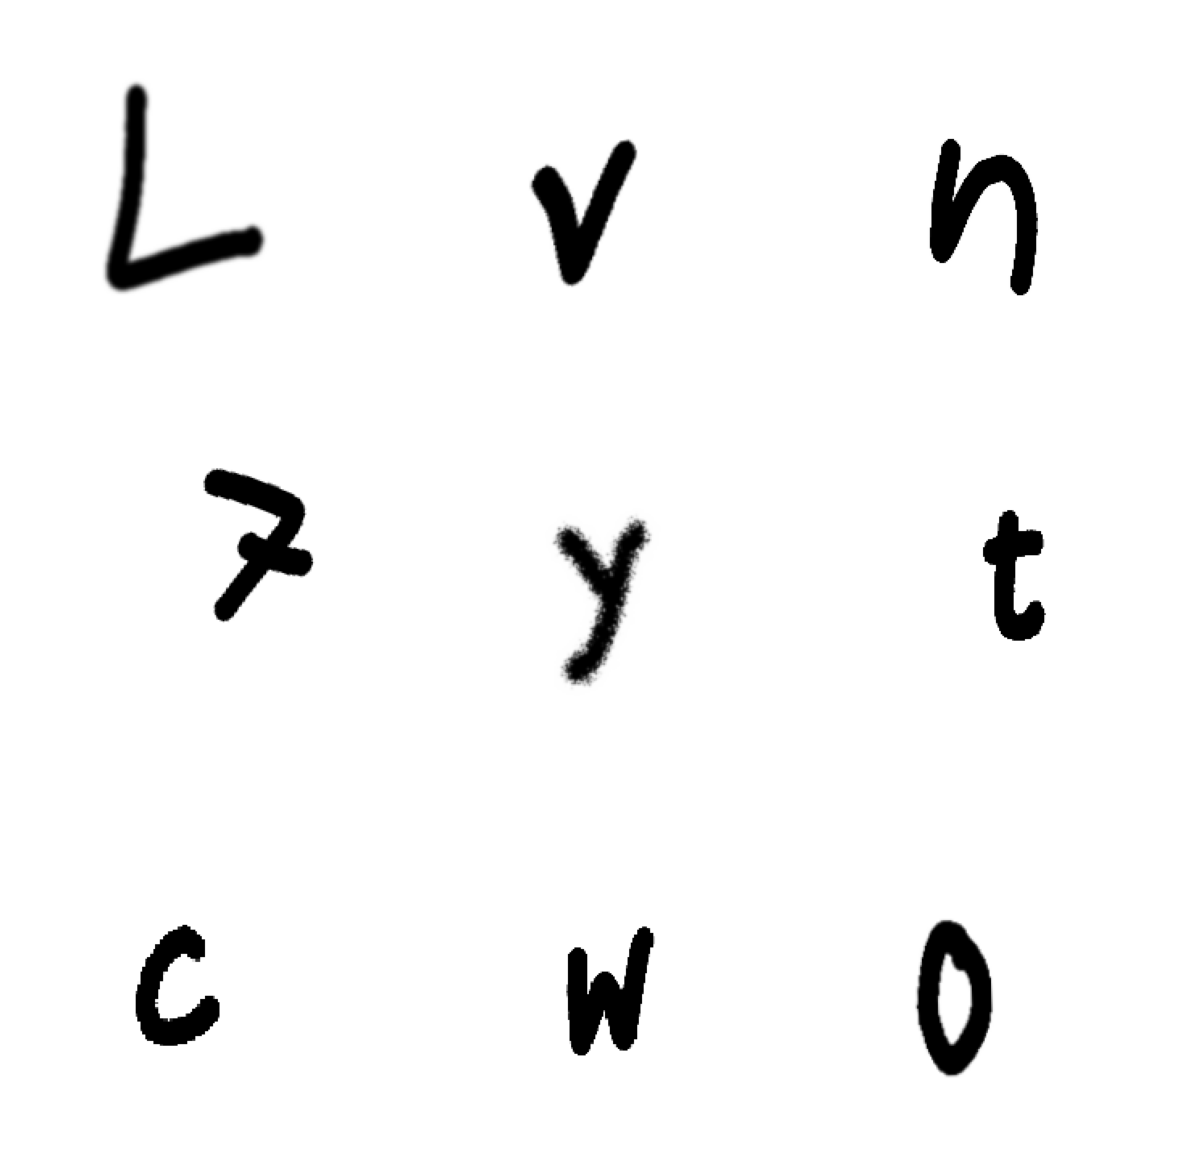

In [28]:
show_augmented_images(xy_train)

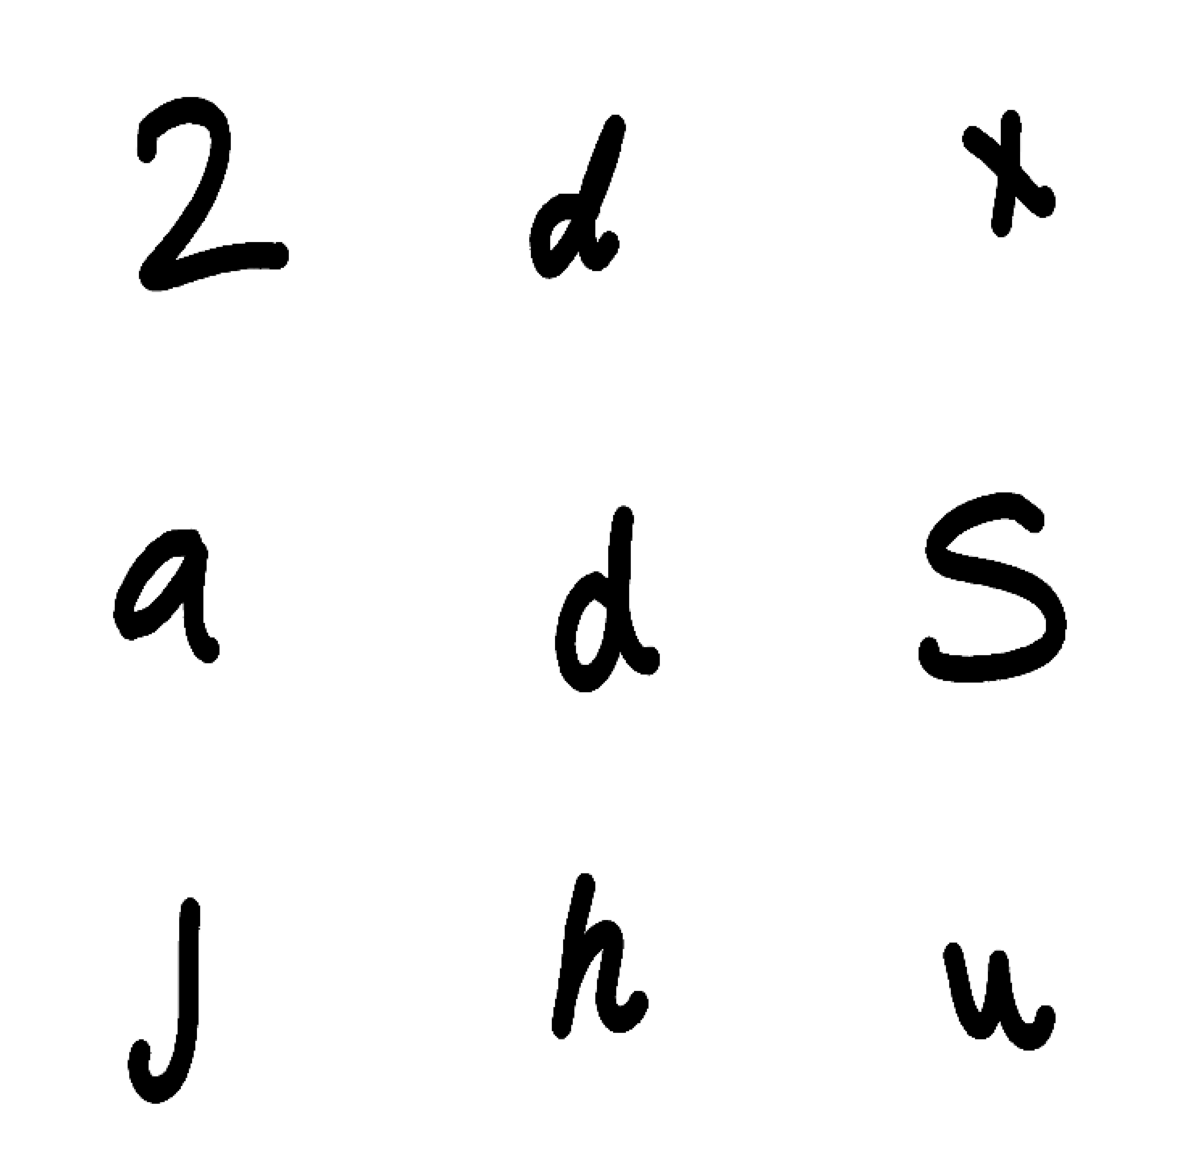

In [29]:
show_augmented_images(xy_val)

# **11. Feature Scaling For Training, Test & Validation Features (After Splitting & Augmentation)**

In [30]:
batch_x_train, batch_y_train = xy_train.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batch_x_train.shape, batch_x_train.min(), batch_x_train.max()))

batch_x_val, batch_y_val= xy_val.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batch_x_val.shape, batch_x_val.min(), batch_x_val.max()))

x_test = x_test.astype("float32")/255
print("Test data shape: " + str(x_test.shape) + ", min: " + str(x_test.min()) + ", max: " + str(x_test.max()))

Batch shape=(64, 224, 224, 3), min=-0.000, max=1.000
Batch shape=(64, 224, 224, 3), min=0.000, max=1.000
Test data shape: (341, 224, 224, 3), min: 0.0, max: 1.0


# **12. Check Shapes (To Input Neural Network)**

In [31]:
input_dim = x_train.shape[1:] #DirectoryIterator: "xy_train.image_shape" or "batch_x_train.shape[1:]"
output_dim = len(classes) #DirectoryIterator: len(xy_train.class_indices)
print(input_dim)
print(output_dim)

(224, 224, 3)
62


# **13. Define Neural Network**

In [32]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(include_top=False, input_shape=input_dim, weights='imagenet')

In [33]:
model = Sequential()
model.add(base_model)
model.add(Flatten()) # Can be used instead of "pooling='avg'" for BETTER ACCURACY!!!
model.add(Dense(256,activation='relu')) # Increases learning_rate & decreases training time per epoch.
model.add(BatchNormalization()) # Optional. Prevents overfitting
model.add(Dense(output_dim, activation='softmax'))

In [34]:
base_model.trainable = True

# **14. Compile The Neural Network**

In [35]:
optimizer = 'Adam'
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

In [36]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# **15. Set Annealers**

In [37]:
import tensorflow as tf
es = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", # metrics to monitor → "val_binary_accuracy", "val_accuracy" 
        patience=20, # how many epochs before stop
        verbose=1,
        mode="auto",
        restore_best_weights=True)

rp = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", # metrics to monitor → "val_binary_accuracy", "val_accuracy" 
        factor=0.2, # The factor by which lr reduced. Typically set to a value between 0.1 and 0.5
        patience=5, # The number of epochs to wait before reducing the learning rate if the monitored metric does not improve. 
        verbose=1, # Controls the output produced during training. 1 -> print message when lr is reduced, 0 -> Disable the output.
        mode="auto", # Determines whether the monitored metric should be minimized or maximized. 
        min_lr=0.00001) # Minimum value to reduce lr. Set to a small value, such as 1e-5 or 1e-6, to ensure that the learning rate does not become too small.

cp = tf.keras.callbacks.ModelCheckpoint(
            filepath='./training_checkpoints/model.h5', # OR filepath=checkpoint_prefix
            monitor='val_loss', # metrics to monitor → "val_binary_accuracy", "val_accuracy", "val_loss", "loss", "accuracy"
            mode="auto", # One of {'auto', 'min', 'max'}. If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, etc. In auto mode, the mode is set to max if the quantities monitored are 'acc' or start with 'fmeasure' and are set to min for the rest of the quantities. 
            save_freq="epoch", # 'epoch'→ Save the model after each epoch | int → Save the model at end of this many batches.
            save_best_only=True, # if True, it only saves when the model based on monitor value. If filepath doesn't contain formatting options like {epoch} then filepath will be overwritten by each new better model. 
            save_weights_only=False, # True → model.save_weights(filepath) | False → model.save(filepath)
            verbose = 1) # Verbosity mode. Mode 0 is silent, mode 1 displays messages when the callback takes an action. 

# **16. Check If GPU Is Enabled**

In [38]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) # This should print 1

Num GPUs Available:  1


# **17. Train The Neural Network**

In [39]:
history = model.fit(xy_train,  # you might need to use "x_train,y_train" instead
          epochs = 50, 
          validation_data = xy_val, # you might need to use "(x_val,y_val)" instead
          batch_size=batch_size,
          callbacks=[rp,cp]) # instead of "rp", you may try "lr" to adjust learning_rate

Epoch 1/50
43/43 [==============================] - 36s 425ms/step - loss: 3.7343 - accuracy: 0.1125 - val_loss: 14.9403 - val_accuracy: 0.0557

Epoch 00001: val_loss improved from inf to 14.94035, saving model to ./training_checkpoints\model.h5
Epoch 2/50
43/43 [==============================] - 10s 231ms/step - loss: 3.0833 - accuracy: 0.2423 - val_loss: 16.6688 - val_accuracy: 0.0147

Epoch 00002: val_loss did not improve from 14.94035
Epoch 3/50
43/43 [==============================] - 10s 231ms/step - loss: 2.7020 - accuracy: 0.3273 - val_loss: 16.1500 - val_accuracy: 0.0117

Epoch 00003: val_loss did not improve from 14.94035
Epoch 4/50
43/43 [==============================] - 10s 229ms/step - loss: 2.2563 - accuracy: 0.4446 - val_loss: 11.5790 - val_accuracy: 0.0176

Epoch 00004: val_loss improved from 14.94035 to 11.57900, saving model to ./training_checkpoints\model.h5
Epoch 5/50
43/43 [==============================] - 10s 233ms/step - loss: 1.7857 - accuracy: 0.5667 - val_lo

43/43 [==============================] - 10s 232ms/step - loss: 0.4174 - accuracy: 0.8941 - val_loss: 0.6951 - val_accuracy: 0.8094

Epoch 00039: val_loss did not improve from 0.65038
Epoch 40/50
43/43 [==============================] - 10s 232ms/step - loss: 0.4410 - accuracy: 0.8871 - val_loss: 0.6909 - val_accuracy: 0.8065

Epoch 00040: val_loss did not improve from 0.65038
Epoch 41/50
43/43 [==============================] - 10s 232ms/step - loss: 0.4418 - accuracy: 0.8779 - val_loss: 0.6891 - val_accuracy: 0.8065

Epoch 00041: val_loss did not improve from 0.65038
Epoch 42/50
43/43 [==============================] - 10s 232ms/step - loss: 0.4461 - accuracy: 0.8860 - val_loss: 0.6875 - val_accuracy: 0.8065

Epoch 00042: val_loss did not improve from 0.65038
Epoch 43/50
43/43 [==============================] - 10s 232ms/step - loss: 0.4349 - accuracy: 0.8820 - val_loss: 0.6882 - val_accuracy: 0.8065

Epoch 00043: val_loss did not improve from 0.65038
Epoch 44/50
43/43 [=============

# **18. Restore Best Model Weights**

In [40]:
model.load_weights('./training_checkpoints/model.h5')

# **19. Evaluate Model's Performance**

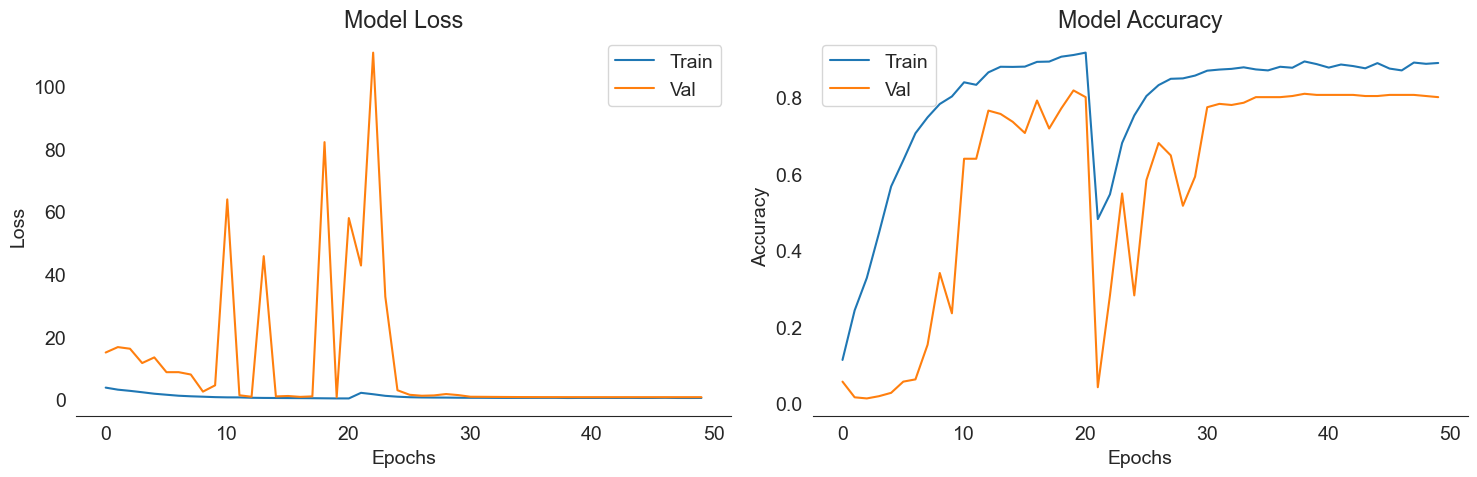

In [41]:
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Val'])

plt.tight_layout()
plt.show()

In [42]:
y_pred = model.predict(x_test, batch_size=batch_size)

In [43]:
y_pred_decoded = (y_pred.argmax(axis=1))

In [44]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"Accuracy is {test_acc}, Loss is {test_loss}")

11/11 [==============================] - 3s 49ms/step - loss: 7.2212 - accuracy: 0.8182
Accuracy is 0.8181818127632141, Loss is 7.2211503982543945


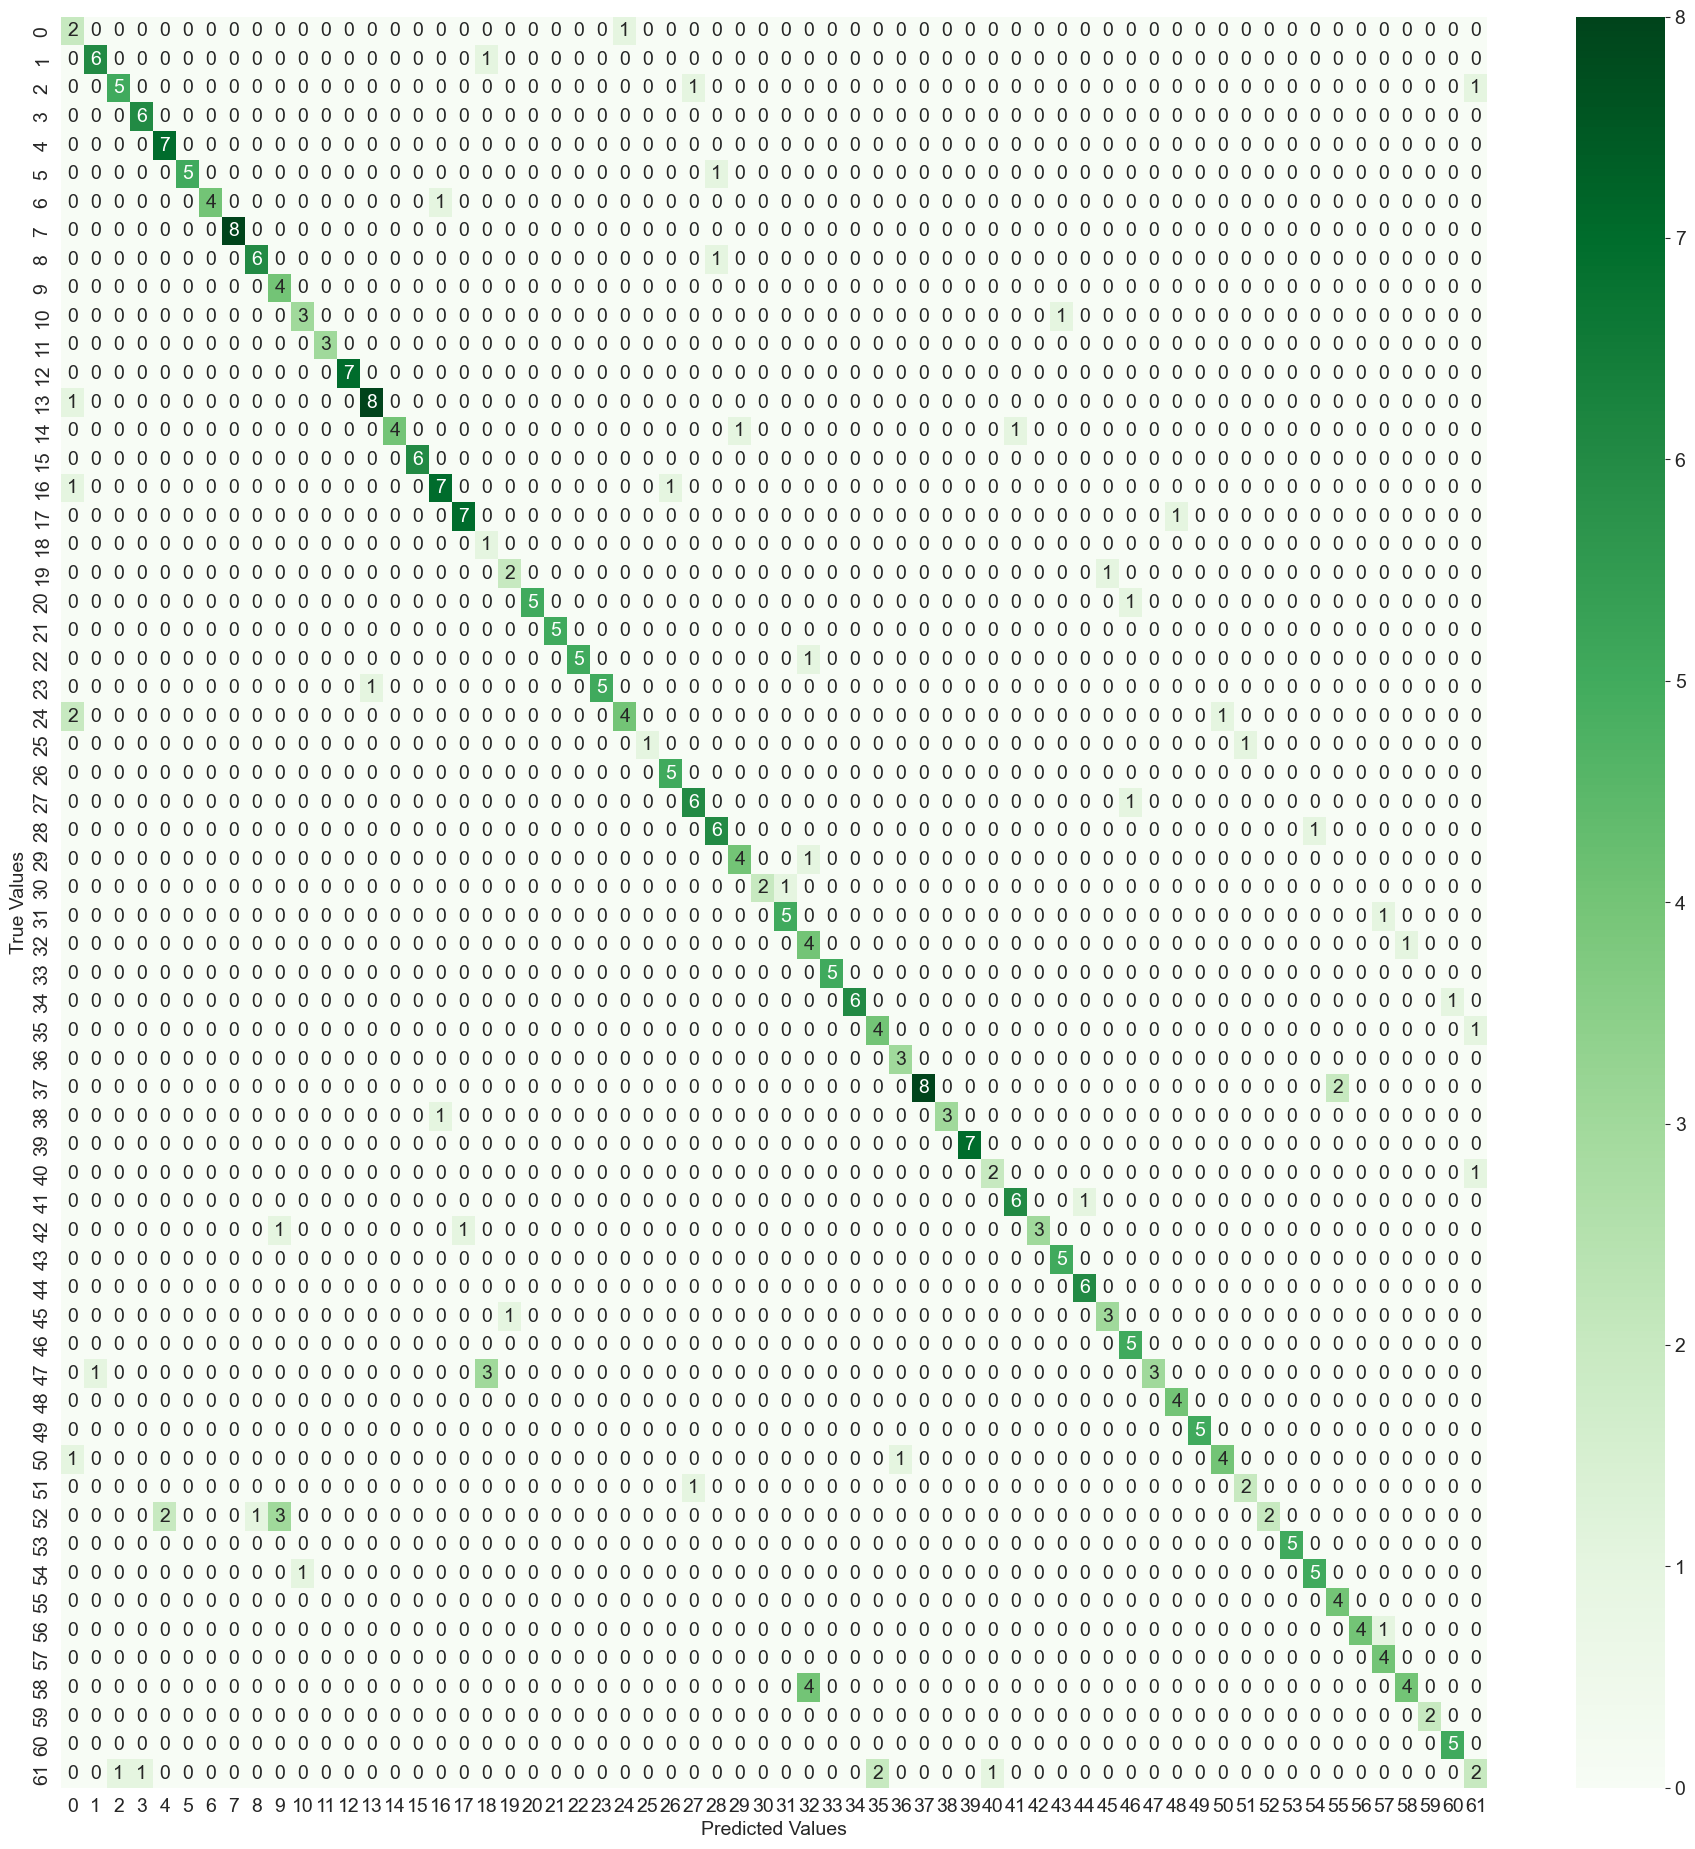

In [45]:
import sklearn
plt.figure(figsize=(23,23))
cm = sklearn.metrics.confusion_matrix(y_test, y_pred_decoded)
sns.heatmap(cm,annot=True, cmap='Greens', linecolor='gray', fmt='.0f')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.show()

I am 72.43688106536865% confident this is ['W']


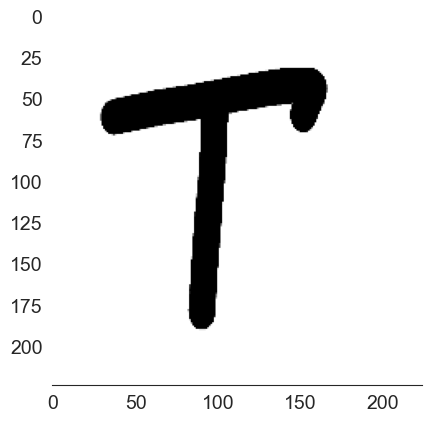

In [46]:
import cv2
img_size=(150,150)

def decode_prediction(y_pred):
    if str(model.layers[-1].activation).split(" ")[1] == "sigmoid":
        return [1 if i > 0.5 else 0 for i in y_pred]
    elif str(model.layers[-1].activation).split(" ")[1] == "softmax":
        return (y_pred.argmax(axis=1))
    else:
        print("Something is wrong")

def show_pred_result(img):
    img_reshaped = img.reshape(1, x_test[0].shape[0], x_test[0].shape[1], 3)
    pred = model.predict(img_reshaped)

    if str(model.layers[-1].activation).split(" ")[1] == "sigmoid":
        conf = np.amax(pred)*100 if np.amax(pred)>0.5 else (1-np.amax(pred))*100
    elif str(model.layers[-1].activation).split(" ")[1] == "softmax":
        conf = np.amax(pred)*100

    pred_decoded = decode_prediction(pred)
    print("I am " + str(conf) + "% confident this is " + str(le.inverse_transform([pred_decoded[0]])))
    plt.imshow(img)

show_pred_result(x_test[0])